In [13]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

import sys
sys.path.insert(0,'..')


import matplotlib.pyplot as plt
from IPython.display import clear_output

import sampler
import camera
import optimization
from sdf import SphereSDF

In [14]:
def lm(x, f, lamb = 1.1):
    y = f(x)
    dx = torch.autograd.grad(y, [x], grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
 
    J = dx.unsqueeze(-1)
    Jt = J.transpose(-2, -1)
    JtJ = torch.matmul(Jt, J)

    k = JtJ.shape[-1]
 
    diag_JtJ = torch.cat([JtJ[..., i, i] for i in range(k)])
    diag_JtJ = diag_JtJ.view(-1, k, 1)
    diag_JtJ = torch.eye(k, device=x.device).unsqueeze(0).expand(diag_JtJ.shape[0], -1, -1) * diag_JtJ
 
    pinv = torch.matmul(torch.inverse(JtJ + lamb * diag_JtJ), Jt)

    delta = - pinv * y.unsqueeze(-1)
    delta = delta[..., 0, :]
 
    return x + delta

In [15]:
cam = camera.PerspectiveCamera()
sdf = SphereSDF(torch.zeros((3)), 1)

# create samples
uv = sampler.grid_2d(64, 64).unsqueeze(0)
depth = torch.zeros((*uv.shape[:-1], 1), device=uv.device).requires_grad_(True)
pose = torch.zeros((4,4), device=uv.device)
pose[:3, :3] = torch.eye(3)
pose[2,3] = -3

foo = lambda d: sdf(cam(uv, d, pose))

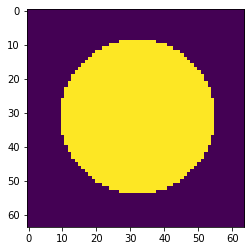

In [16]:
import matplotlib.pyplot as plt

for i in range(10):
    clear_output(wait=True)
    plt.imshow(foo(depth).detach().numpy().reshape(64,64,1) < 1e-6)
    #plt.imshow(depth.detach().numpy().reshape(64,64,1))
    plt.show()
    
    depth = optimization.lm(depth, foo, 1e-4)
    
mask_gt = F.sigmoid(- foo(depth) / 1e-3).view(64,64,1).detach()

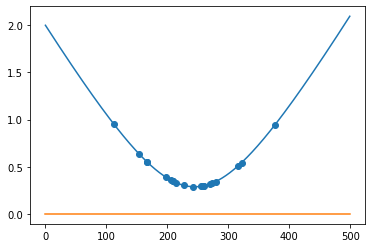

In [17]:
li = []
li2 = []
li3 = []

for i in range(500):
    li.append(foo(torch.ones(*uv.shape[:-1], 1, device=uv.device) * 1e-2 * i)[0, 10*64+10, 0])

for i in range(20):
    depth = optimization.lm(depth, foo)
    ff = foo(depth)
    
    li2.append(depth[0, 10*64+10, 0].item() * 100)
    li3.append(ff[0, 10*64+10, 0].item())
    
plt.plot(range(500), li)
plt.plot(range(500), [0]*500)
plt.scatter(li2, li3)

In [18]:
cam = camera.PerspectiveCamera()
pos = torch.randn((3)) * 5e-1
pos.requires_grad_(True)

sdf = SphereSDF(pos, 1)

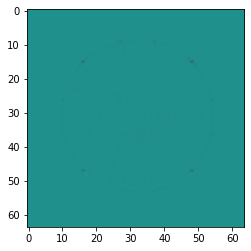

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

adam = Adam([pos], lr=1e-2)
li = []
for j in range(100):
    # create samples
    uv = sampler.grid_2d(64, 64).unsqueeze(0)
    depth = torch.zeros((*uv.shape[:-1], 1), device=uv.device).requires_grad_(True)
    pose = torch.zeros((4,4), device=uv.device)
    pose[:3, :3] = torch.eye(3)
    pose[2,3] = -3
    
    for i in range(5):
        #plt.imshow(F.sigmoid(- foo(depth) / 1e-3).detach().numpy().reshape(64,64,1))
        #plt.show()
        depth = optimization.lm(depth, foo, 1e-4)
        
    mask = F.sigmoid(- foo(depth) / 1e-3).view(64,64,1)
    
    clear_output(wait=True)
    
    plt.imshow((mask - mask_gt).detach().numpy())
    plt.clim(-1,1)
    plt.show()

    adam.zero_grad()
    loss = ((mask - mask_gt) ** 2).mean()
    li.append(loss.item())
    loss.backward()
    adam.step()


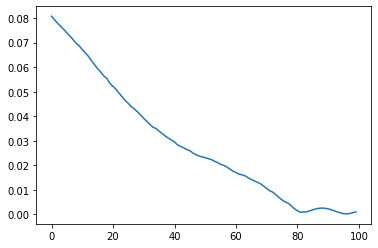

In [33]:
plt.plot(range(100), li)